# encoder-GAN learnable latent mapping

### Description of idea

There exists problem of GAN inversion, where we want to learn a map to latent codes of GAN, which ultimately enables us to edit images in latent space and produce transitions from one another.

What we want to try is to utilize latent space of pretrained encoder, which was trained in ss contrastive manner (cause we know that it's latent space is great). We want to learn mapping $m(\cdot)$ from latent space of this encoder to latent space of encoder to latent space of GAN. 

We also propose a new pipeline for this kind of training. Usually there exists a complex pipeline starting from image which is encoded into latent, then mapped, then decoded by GAN into generated image. This pipeline suggest usage of complex 'consistency' losses, which account for reconstruction of image being inverted from latent codes. Instead we suggest to start from latent codes, generate an image and then encode it. This naturally eliminates needs for any consistency loss, as we are operating purely on latents.

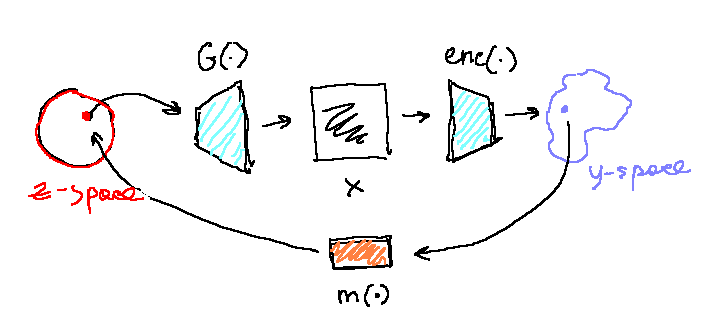

Here, only mapping $m(\cdot)$ is trainable, everything else is pretrained and fixed!

## Simplest experiment with MNIST dataset

For our simplest experiment, we need to obtain two things

- generator $G(\cdot)$ from GAN training on MNIST
- self-supervised trained encoder $enc(\cdot)$, also trained on MNIST

After that, we are ready to learn our mapping $m(\cdot)$.

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# !pip install lightly -q

In [1]:
from train_gan import Generator
from train_encoder import SimCLR

import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

from utils import *

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value

In [2]:
from pathlib import Path
dir_models = Path('models/')
dir_models.mkdir(exist_ok=True)

dir_logs = Path('logs')
dir_logs.mkdir(exist_ok=True)

## Trying to fit map with CLIP-image encoder

Training custom encoder on same data domain is fine, but ideally we would like to utilize some big pretrained thing with good embeddings for the suppoert of generation model. Let's try this with CLIP

In [6]:
# check on other random samples
eval_samples = torch.stack([holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]).to(DEVICE)
_, axs = plt.subplots(2, 5, figsize=(25, 10))
mapping.eval()
with torch.no_grad():
    y = E(eval_samples).squeeze()
    z_hat = mapping(y)[:,:, None, None]
    inv_samples = G(z_hat)

for i in range(5):
    img_orig = eval_samples[i].cpu().numpy().reshape((28, 28))
    img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
    axs[0][i].imshow(img_orig)
    axs[1][i].imshow(img_invers)
plt.show()

NameError: name 'holdout_mnist' is not defined

In [6]:
import clip

In [7]:
model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [8]:
import torch
from datasets import load_dataset
from pytorch_pretrained_gans import make_gan

dataset = load_dataset("merkol/ffhq-256")['train']

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='stylegan2').to("cuda")

#G = G.to(DEVICE)
z = G.sample_latent(batch_size=1, device='cuda')  # -> torch.Size([1, 18, 512])
x = G(z=z)  # -> torch.Size([1, 3, 1024, 1024])
assert z.shape == torch.Size([1, 18, 512])
assert x.shape == torch.Size([1, 3, 1024, 1024])

Added /home/natifick/miniconda3/lib/python3.12/site-packages/pytorch_pretrained_gans/stylegan2_ada_pytorch to path
Setting up PyTorch plugin "bias_act_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


/home/natifick/miniconda3/lib/python3.12/site-packages/pytorch_pretrained_gans/stylegan2_ada_pytorch/torch_utils/ops/bias_act.py:50: UserWarning: Failed to build CUDA kernels for bias_act. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/natifick/miniconda3/lib/python3.12/site-packages/pytorch_pretrained_gans/stylegan2_ada_pytorch/torch_utils/ops/bias_act.py", line 48, in _init
    _plugin = custom_ops.get_plugin('bias_act_plugin', sources=sources, extra_cuda_cflags=['--use_fast_math'])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/natifick/miniconda3/lib/python3.12/site-packages/pytorch_pretrained_gans/stylegan2_ada_pytorch/torch_utils/custom_ops.py", line 110, in get_plugin
    torch.utils.cpp_extension.load(name=module_name, verbose=verbose_build, sources=sources, **build_kwargs)
  File "/home/natifick/miniconda3/lib/python3.12/site-packages/torch/u

In [9]:
z = G.sample_latent(batch_size=1000, device="cuda")
z.mean(), z.std()

(tensor(0.0971, device='cuda:0'), tensor(0.3909, device='cuda:0'))

In [10]:
z.mean(dim=2).mean(dim=0)

tensor([0.0971, 0.0971, 0.0971, 0.0971, 0.0971, 0.0971, 0.0971, 0.0971, 0.0970,
        0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970],
       device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


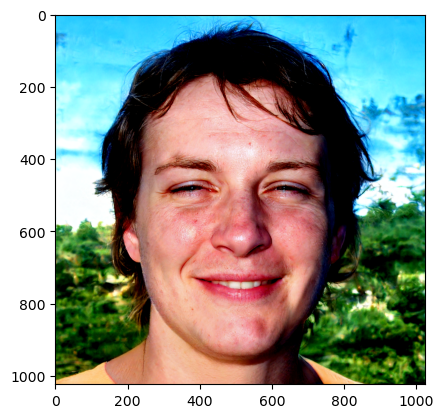

In [11]:
z = G.sample_latent(batch_size=1, device='cuda')  # -> torch.Size([1, 18, 512])
#z[:, 0, :][:, None].repeat([1, 18, 1])
x = G(z=z)  # -> torch.Size([1, 3, 1024, 1024])
img = x.detach().cpu().numpy()[0]
plt.imshow(np.rollaxis(img, 0, 3))

In [12]:
class BroadcastChannelTransform(object): # used to broadcast mnist image tensors
    def __init__(self, output_ch=3):
        self.output_ch = output_ch

    def __call__(self, images: torch.Tensor):
        if len(images.shape) == 4:
            bs, _, h, w = images.shape
            return images.broadcast_to((bs, self.output_ch, h, w))
        else:
            image = images
            _, h, w = image.shape
            return image.broadcast_to(self.output_ch, h, w)
        
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean=0.5, std=0.5):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
    
denormalize = NormalizeInverse()
to_pil = T.ToPILImage()

In [13]:
G.requires_grad_(False)         

n_px=model.visual.input_resolution
clip_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    BroadcastChannelTransform(3),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [14]:
eval_samples = [dataset[idx]["image"] for idx in random.sample(range(len(dataset["image"])), k=5)]

eval_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    T.ToTensor(),
    BroadcastChannelTransform(3),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

## Try replicating CLIP2GAN paper

In [31]:
class M_wplus(nn.Module):
    """Learnable projection from y-space to w+-space"""
    def __init__(self, n_hidden_layers, hidden_dim, y_dim, num_ws, z_dim):
        super().__init__()
        layers = [nn.Linear(y_dim, hidden_dim)]
        for _ in range(n_hidden_layers):
            layers += [nn.GELU(), nn.Linear(hidden_dim, hidden_dim)]
        layers += [nn.GELU(), nn.Linear(hidden_dim, num_ws * z_dim)]
        self.shape = (-1, num_ws, z_dim)
        self.projection = nn.Sequential(*layers)

    def forward(self, y):
        projected = self.projection(y)
        projected = projected.reshape(self.shape)
        return projected

In [44]:
from IPython.display import clear_output

def train_latent_map_clip(
        mapping: nn.Module, 
        generator: nn.Module, 
        encoder: nn.Module, 
        loss_fn, # loss function used on latents
        optimizer, 
        num_iters=5000, 
        eval_iters=1000, # ? 
        batch_size=512, 
        ema=None,
        image_augmentations=None,
        args=AttributeDict(),
        plot_every=None,
    ):
    generator.eval()
    encoder.eval()
    mapping.train()
    resizer = T.Resize([224, 224])

    loss_hist = []
    p_bar = tqdm(range(num_iters))
    for i in p_bar:
        optimizer.zero_grad()
        z = G.sample_latent(batch_size=batch_size, device=DEVICE) # torch.randn((batch_size, z_dim), device=DEVICE)
        with torch.no_grad():
            images = denormalize(generator(z)) # [:, None].repeat([1, generator.num_ws, 1])
            # Saving images for later reconstruction loss
            if args.loss_reconstruction is not None:
                images_original = images.clone()
            if image_augmentations is not None:
                images = image_augmentations(images)
            images = clip_transform(images)
            y = encoder.encode_image(images).squeeze(0).float()
            if args.add_noise:
                y += args.nl * torch.randn_like(y)

        loss = 0
        z_hat = mapping(y)
        imgs_hat = denormalize(generator(z_hat))
        # Basic adversarial loss
        if args.loss_adversarial is not None:
            loss += args.adv_loss_scale * args.loss_adversarial(mapping, y, z)    
        # Images should be diverse
        if args.loss_diversity is not None:
            z_hat_noisy = mapping(y + torch.randn_like(y))
            imgs_hat_noisy = denormalize(generator(z_hat_noisy))
            y_hat_noisy = encoder.encode_image(resizer(imgs_hat_noisy)).squeeze(0).float()
            loss += args.div_loss_scale * args.loss_diversity(imgs_hat, imgs_hat_noisy, y, y_noisy)
        # Images should represent the same thing
        if args.loss_perceptual is not None:
            loss += args.perc_loss_scale * args.loss_perceptual(imgs_hat, images_original)
        # images should be close to each other
        if args.loss_reconstruction is not None:
            loss += args.rec_loss_scale * args.loss_reconstruction(imgs_hat, images_original)
        # Discriminator to detect wrong images
        if args.dicriminator is not None:
            dicriminator()
        
        loss.backward()
        optimizer.step()
        if ema is not None:
            ema.update()
        
        loss_hist.append(loss.item())
        p_bar.set_postfix(loss=loss.item())
        
        if plot_every is not None:
            if i % plot_every == 0:
                clear_output(wait=True)
                visualize_inversion_clip(eval_samples, mapping, encoder=model,)
        
    return loss_hist, mapping

@torch.no_grad()
def visualize_inversion_clip(eval_samples, mapping, encoder, saved_weights_path=None):
    if saved_weights_path is not None:
        mapping.load_state_dict(torch.load(saved_weights_path))
        
    mapping.eval()
    images=torch.stack([eval_transform(img) for img in eval_samples]).to(DEVICE)
    y = encoder.encode_image(images).squeeze(0).float()
    z_hat = mapping(y)
    inv_samples = denormalize(G(z_hat))

    _, axs = plt.subplots(2, 5, figsize=(16, 6))
    for i in range(5):
        print()
        img_orig = np.array(eval_samples[i])
        img_invers = np.rollaxis(inv_samples[i].cpu().numpy(), 0, 3)
        axs[0][i].imshow(img_orig)
        axs[1][i].imshow(img_invers)
    plt.show()

In [45]:
def diversity_loss(imgs_hat, images_hat_noisy, y, y_noisy):
    return torch.mean(torch.sum(torch.sign(y - y_noisy), dim=(1)) \
                      / torch.sum(torch.sign(imgs_hat - images_hat_noisy), dim=(1, 2, 3)))

In [46]:
from piq import LPIPS

# Just a useful thing to not get too large gradients
torch.autograd.detect_anomaly(True)

args = AttributeDict()

args.add_noise = True
args.nl = 0.1

args.adv_loss_scale = 0.1
args.loss_adversarial = adversarial_loss

args.div_loss_scale = 1.5
args.loss_diversity = diversity_loss

args.perc_loss_scale = 1
args.loss_perceptual = LPIPS()

args.rec_loss_scale = 1
args.loss_reconstruction = F.l1_loss


G.requires_grad_(False)
# mapping model
z_dim=G.dim_z
num_ws=G.num_ws
y_dim=512
n_hidden=4
hidden_dim=512

# training utils
mapping = M_wplus(n_hidden, hidden_dim, y_dim, num_ws, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=5e-5)
batch_size = 2

masking_loss_hist, mapping = train_latent_map_clip(
    mapping=mapping, 
    generator=G, 
    encoder=model, 
    loss_fn=F.l1_loss,
    optimizer=optimizer, 
    num_iters=500, 
    batch_size=batch_size,
    # image_augmentations=T.RandomErasing(),
    args=args,
    plot_every=None
)

torch.save(mapping.state_dict(), f"models/mapping_clip_b_{n_hidden}_{hidden_dim}.pth")
plot_losses({"masking_loss_hist": masking_loss_hist})
visualize_inversion_clip(
    eval_samples, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

/tmp/ipykernel_10631/823111731.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  torch.autograd.detect_anomaly(True)
/home/natifick/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/natifick/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'y_noisy' is not defined

In [29]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [49]:
#del optimizer
#del mapping
#del model
del G